In [ ]:
# reference: https://github.com/selimsef/dsb2018_topcoders/blob/867f5f357179e1c033b50cd93571859b97ad5c22/albu/src/augmentations/transforms.py#L14
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# list files
import os
os.listdir('drive/MyDrive/mitosis_data')

['A00_01.bmp',
 'A00_05.bmp',
 'UNET-Best.h5',
 '23.jpg',
 '25.jpg',
 '30.jpg',
 'MitoSegNet_model.hdf5',
 'patch_A00_v2',
 'pretrained_weights.h5',
 '04_1.png',
 '04_8.png']

In [49]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
# test image: A00_01 of data: ICPR12/MITOS12   (images are in RGB)
# ref data: http://ludo17.free.fr/mitos_2012/index.html
image_path = "drive/MyDrive/mitosis_data/A00_01.bmp"

# read image with imread module cv2 (opencv for python), this use BGR to read images
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2_imshow(image)

size of patch:  (256, 256, 3)


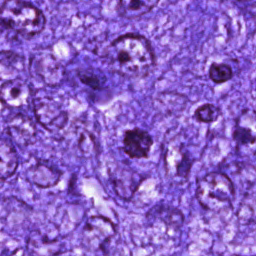

In [ ]:

# generate patch example
import numpy as np

h, w = 300, 600
patch_center = np.array([h, w])

# calc patch position and extract it
patch_size = 256
patch_x = int(patch_center[0] - patch_size / 2.) if patch_center[0] > patch_size / 2. else patch_center[0]
patch_y = int(patch_center[1] - patch_size / 2.) if patch_center[1] > patch_size / 2. else patch_center[1]
patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]

print('size of patch: ', patch_image.shape)
cv2_imshow(patch_image)

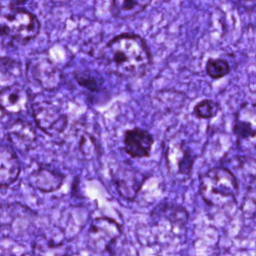

In [ ]:
# needed method
def to_tuple(param, low=None):
    if isinstance(param, tuple):
        return param
    else:
        return (-param if low is None else low, param)


# angle rotations
def rotate(img, angle=30, k_limit=(1, 6), seed=None):
    if seed is None:
        random_state = np.random.RandomState(1234)
    else:
        random_state = np.random.RandomState(seed)
    angle = random_state.randint(k_limit[0], k_limit[1])
    height, width = img.shape[0:2]
    mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
    img = cv2.warpAffine(np.float32(img), mat, (width, height),
                      flags=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_REFLECT_101)    
    return img

cv2_imshow(rotate(patch_image,seed=6))

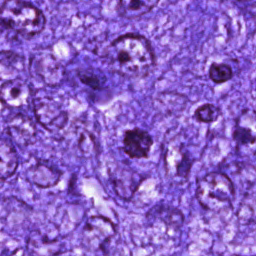

In [ ]:
# blur
def blur(img, k_max=5, seed=None):
    if seed is None:
        random_state = np.random.RandomState(1234)
    else:
        random_state = np.random.RandomState(seed)
    
    k_limit = to_tuple(k_max, low=1)
    ksize = random_state.randint(k_limit[0], k_limit[1])
    return cv2.blur(img, (ksize, ksize))

cv2_imshow(blur(patch_image, k_max=2))

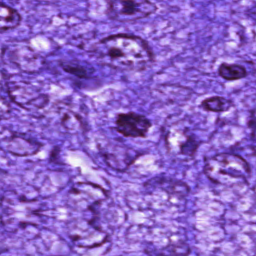

True

In [ ]:
from scipy.ndimage.filters import gaussian_filter
def elastic_transform(image, alpha=1, sigma=30, alpha_affine=3, seed=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if seed is None:
        random_state = np.random.RandomState(1234)
    else:
        random_state = np.random.RandomState(seed)

    shape = image.shape
    shape_size = shape[:2]


    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    alpha = float(alpha)
    sigma = float(sigma)
    alpha_affine = float(alpha_affine)

    pts1 = np.float32([center_square + square_size, [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)

    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = np.float32(gaussian_filter((random_state.rand(*shape_size) * 2 - 1), sigma) * alpha)
    dy = np.float32(gaussian_filter((random_state.rand(*shape_size) * 2 - 1), sigma) * alpha)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

    mapx = np.float32(x + dx)
    mapy = np.float32(y + dy)

    return cv2.remap(image, mapx, mapy, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

cv2_imshow(elastic_transform(patch_image, alpha=1, sigma=30, alpha_affine=30, seed=500))

a = elastic_transform(patch_image, alpha=1, sigma=30, alpha_affine=30, seed=500)
b = elastic_transform(patch_image, alpha=1, sigma=30, alpha_affine=30, seed=500)
(a==b).all()



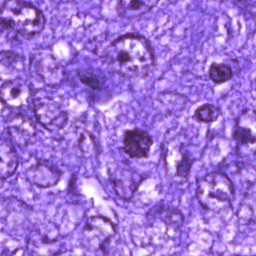

In [ ]:
# gaussian noise (only on images, not in masks!)
def gaussian_noise(image, var_limit=(10,30), seed=None):
    if seed is None:
        random_state = np.random.RandomState(1234)
    else:
        random_state = np.random.RandomState(seed)
    row, col, ch = image.shape
    var = random_state.randint(var_limit[0], var_limit[1])
    mean = var
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss = (gauss - np.min(gauss)).astype(np.uint8)
    return image.astype(np.int32) + gauss

cv2_imshow(gaussian_noise(patch_image))

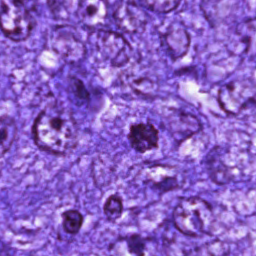

True

In [ ]:
# distorsion
# isinstance((-0.05, 0.05), tuple)
import random

def distorsion(img, distort_limit=(-0.05,0.05), shift_limit=(-0.05,0.05), seed=None):
  """"
  ## unconverntional augmnet ################################################################################3
  ## https://stackoverflow.com/questions/6199636/formulas-for-barrel-pincushion-distortion
  ## https://stackoverflow.com/questions/10364201/image-transformation-in-opencv
  ## https://stackoverflow.com/questions/2477774/correcting-fisheye-distortion-programmatically
  ## http://www.coldvision.io/2017/03/02/advanced-lane-finding-using-opencv/
  ## barrel\pincushion distortion
  """
  if seed is None:
      random_state = np.random.RandomState(1234)
  else:
      random_state = np.random.RandomState(seed)
  
  shift_limit = to_tuple(shift_limit)
  distort_limit = to_tuple(distort_limit)
  shift_limit = to_tuple(shift_limit)
  k = random_state.uniform(distort_limit[0], distort_limit[1])
  dx = random_state.uniform(shift_limit[0], shift_limit[1])
  dy = random_state.uniform(shift_limit[0], shift_limit[1])
  k = k * 0.00001

  height, width = img.shape[:2]
  dx = dx * width
  dy = dy * height
  x, y = np.mgrid[0:width:1, 0:height:1]
  x = x.astype(np.float32) - width/2 - dx
  y = y.astype(np.float32) - height/2 - dy
  theta = np.arctan2(y, x)
  d = (x*x + y*y)**0.5
  r = d*(1+k*d*d)
  map_x = r*np.cos(theta) + width/2 + dx
  map_y = r*np.sin(theta) + height/2 + dy
  img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
  return img

cv2_imshow(distorsion(patch_image, distort_limit=0.3, shift_limit=0.3))

a = distorsion(patch_image, distort_limit=0.3, shift_limit=0.3)
b = distorsion(patch_image, distort_limit=0.3, shift_limit=0.3)
(a==b).all()



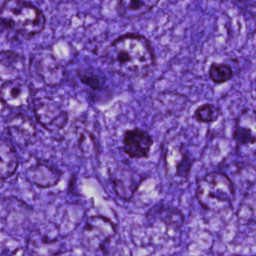

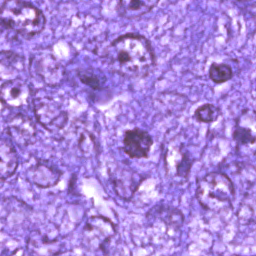

In [ ]:
# random brightness
def random_brightness(img, alpha=.2, seed=None):
    if seed is None:
      random_state = np.random.RandomState(1234)
    else:
      random_state = np.random.RandomState(seed)
    limit = to_tuple(alpha)
    alpha = 1 + random_state.uniform(limit[0], limit[1])
    return alpha * img
cv2_imshow(random_brightness(patch_image, alpha=.2))

# random contrast 
def random_contrast(img, alpha=.2, seed=None):
  if seed is None:
    random_state = np.random.RandomState(1234)
  else:
    random_state = np.random.RandomState(seed)
  limit = to_tuple(alpha)
  alpha = 1 + random_state.uniform(limit[0], limit[1])
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
  return alpha * img + gray
cv2_imshow(random_contrast(patch_image, alpha=.2))    
   

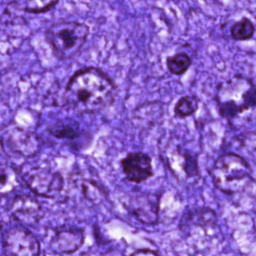

True

In [ ]:
import math
# shift scale rotate (molt utilitzat)
def shift_scale_rotate(img, shift_limit=0.2, scale_limit=0.1, rotate_limit=45, seed=None):
    if seed is None:
        random_state = np.random.RandomState(1234)
    else:
        random_state = np.random.RandomState(seed)

    shift_limit = to_tuple(shift_limit)
    scale_limit = to_tuple(scale_limit)
    rotate_limit = to_tuple(rotate_limit)
    angle = random_state.uniform(rotate_limit[0], rotate_limit[1])
    scale = random_state.uniform(1 + scale_limit[0], 1 + scale_limit[1])
    dx = random_state.uniform(shift_limit[0], shift_limit[1])
    dy = random_state.uniform(shift_limit[0], shift_limit[1])

    height, width = img.shape[:2]

    cc = math.cos(angle/180*math.pi) * scale
    ss = math.sin(angle/180*math.pi) * scale
    rotate_matrix = np.array([[cc, -ss], [ss, cc]])

    box0 = np.array([[0, 0], [width, 0],  [width, height], [0, height], ])
    box1 = box0 - np.array([width/2, height/2])
    box1 = np.dot(box1, rotate_matrix.T) + np.array([width/2+dx*width, height/2+dy*height])

    box0 = box0.astype(np.float32) 
    box1 = box1.astype(np.float32)
    mat = cv2.getPerspectiveTransform(box0, box1)
    img = cv2.warpPerspective(img, mat, (width, height),
                                          flags=cv2.INTER_LINEAR,
                                          borderMode=cv2.BORDER_REFLECT_101)

    return img

cv2_imshow(shift_scale_rotate(patch_image))

a = shift_scale_rotate(patch_image)
b = shift_scale_rotate(patch_image)
(a==b).all()



In [ ]:
# data augmentation pipeline
# Constructs data augmentation pipeline method
def aug_generator(image, mask, seed=12):
    # noise
    if random.uniform(0, 1.0) < 0.5:
        image = gaussian_noise(patch_image, seed=seed)
    
    # rotation
    image = rotate(image, seed=seed)
    mask  =  rotate(mask, seed=seed)

    # blur
    if random.uniform(0, 1.0) < 0.3:
        image = blur(patch_image, seed=seed)
    
    # transformation
    # shift scale 
    if random.uniform(0, 1.0) < 0.7:
        image = shift_scale_rotate(image, seed=seed)
        mask = shift_scale_rotate(mask, seed=seed)
    # distorsion
    if random.uniform(0, 1.0) < 0.5:
      f = np.random.choice([elastic_transform, distorsion], 1)[0]
      image = f(image, seed=seed)
      mask = f(mask, seed=seed)
    
    # contrast or brightness
    if random.uniform(0, 1.0) < 0.4:
      f = np.random.choice([random_brightness, random_contrast], 1)[0]
      image = f(image, seed=seed)
      
    return image, mask

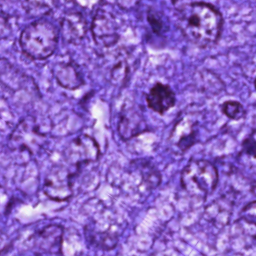

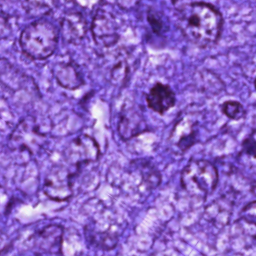

In [ ]:
image, mask = aug_generator(patch_image, patch_image, seed=6)

cv2_imshow(image)
cv2_imshow(mask)
